## Initalizing Libraries

In [1]:
import pandas as pd
from pulp import *
import numpy as np
from scipy.optimize import minimize
import math
import time
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Import Data


### Demand per SKU

In [2]:
# Demand
df_demand = pd.read_csv(r"F:/NYIT/DTSC-615_Optimazition for Data Science/Project/df_demandsku.csv", index_col=0)
print("{:,} total demand".format(df_demand.DEMAND.sum()))
df_demand.head()

9,170 total demand


,SKU,DEMAND
0,D1,218
1,D2,277
2,D3,62
3,D4,142
4,D5,146


In [3]:
df1 = df_demand.copy()

In [4]:
df2 = pd.DataFrame(df1.groupby(by = ['SKU','DEMAND']).sum().reset_index())
df2 = df2.sort_values(['DEMAND'],ascending=False)
df2 = df2[:5]
df2

,SKU,DEMAND
52,D57,295
1,D10,294
47,D52,290
31,D38,285
37,D43,281


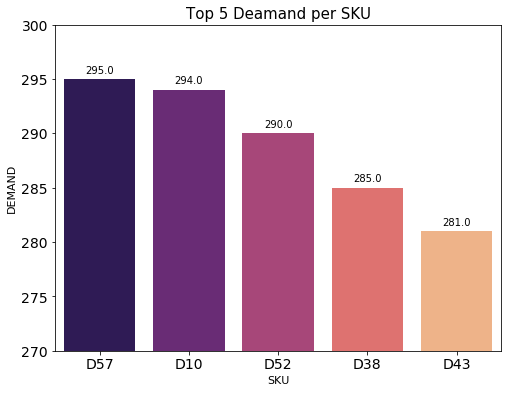

In [5]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(x = 'SKU', y = 'DEMAND', data = df2,palette = 'magma')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax.set_title("Top 5 Deamand per SKU", fontsize=15)
ax.set_xlabel("SKU", fontsize=11)
ax.set_ylabel("DEMAND", fontsize=11)
ax.tick_params(labelsize=14)
plt.ylim(270,300)
plt.show()

### Cost per Carton

In [6]:
df_costsku = pd.read_csv(r"F:/NYIT/DTSC-615_Optimazition for Data Science/Project/df_costsku.csv", index_col=0)
print("{:,} average cost per carton".format(df_costsku.COST.mean()))
df_costsku.head()

186.1 average cost per carton


,SKU,COST
0,D1,181
1,D2,126
2,D3,144
3,D4,238
4,D5,315


In [7]:
df3 = df_costsku.copy()

In [8]:
df4 = pd.DataFrame(df3.groupby(by = ['SKU','COST']).sum().reset_index())
df4 = df4.sort_values(['COST'],ascending=False)
df4 = df4[:5]
df4

,SKU,COST
24,D31,324
25,D32,322
35,D41,317
44,D5,315
34,D40,312


In [9]:
import plotly.express as px

In [11]:
fig = px.pie(df4, values="COST" , names ="SKU",color_discrete_sequence = px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title = 'Top 5 Cost per Carton')
fig.show()

### Transportation Costs

In [95]:
A = -0.3975
b = 42.250

### Build the model

### Define the objective function

In [96]:
# Parameters for Transportation costs
A = -0.3975
b = 42.250

# Define the Objective Function
def objective(R):
    result = 0
    for i in range(60):
        # TR Costs
        result += (A*(df_demand.loc[i,'DEMAND']/R[i]) + b) * R[i]
        # Capital Costs
        result += (df_demand.loc[i,'DEMAND']/(2*R[i])) * df_costsku.loc[i,'COST']*0.125
        # Storage Costs
        result += (df_demand.loc[i,'DEMAND']/(2*R[i])) * 12 * 480/2000
    return result 

### Add Constraints

### Constraint 1: Maximum inventory

In [97]:
# Initialize constraints list
cons = []
# Maximum Inventory
def constraint1(R):
    loop = 0 
    for i in range(60):
        loop += R[i]
    result = 480 - loop
    return result
cons.append({'type':'ineq','fun':constraint1})

### Constraint 2: Order Size

In [98]:
# Add Order Size Constraints
for i in range(60):
    # Minimum Order Quantity
    c2 = lambda R : (df_demand.loc[i,'DEMAND']/R[i]) - 1
    cons.append({'type':'ineq','fun':c2})
    # Maximum Order Quantity
    c3 = lambda R : 400 - (df_demand.loc[i,'DEMAND']/R[i]) 
    cons.append({'type':'ineq','fun':c3})

### Solve

### Initial value (guessing)

In [99]:
# All SKU replenished 1 time
R0 = [2 for i in range(60)]
print("${:,} total cost for initial guessing".format(objective(R0).round(1)))

$63,206.7 total cost for initial guessing


### Bounds

In [100]:
# Bound vector
b_vector = (1, 365)
bnds = tuple([b_vector for i in range(60)])


### Solve with 100 iterations

In [101]:
start = time.time()
sol = minimize(objective, R0, method = 'SLSQP', bounds=bnds, constraints = cons, options={'maxiter': 100})
exec_time = (time.time()-start)
print("Execution time is {}s for 100 iterations".format(exec_time))

Execution time is 85.12501788139343s for 100 iterations


### Solution values

In [102]:
# Initial solution
sol_init = sol.x
# Take the floor of the solution to have an integer as number of replenishment and never exceed stock limit 
sol_final = [math.floor(i) for i in sol_init]

### Solution Results

In [128]:
print(('''For {} Iterations-> Initial Solution: ${:,} -> Integer Solution: ${:,}''').format(100, sol.fun, objective(sol_final)))
print("Maximum inventory level with continuous number of replenishment: {}".format(sum(sol_init)))
print("Maximum inventory level with continuous number of replenishment: {}".format(sum(sol_final)))

For 100 Iterations-> Initial Solution: $28,991.880313655496 -> Integer Solution: $29,221.343179022373
Maximum inventory level with continuous number of replenishment: 386.2361790436466
Maximum inventory level with continuous number of replenishment: 356


In [124]:
X1, X2 = np.meshgrid(a1,a2)
Y = np.sqrt(np.square(X1) + np.square(X2))

In [16]:
#Solve with 500 iterations
start = time.time()
sol = minimize(objective, R0, method = 'SLSQP', bounds=bnds, constraints = cons, options={'maxiter': 500})
exec_time = (time.time()-start)
print("Execution time is {}s for 500 iterations".format(exec_time))

Execution time is 38.740915060043335s for 500 iterations


In [17]:
#Solution values
# Initial solution
sol_init2 = sol.x
# Take the ceiling of the solution to have an integer as number of replenishment
sol_final2 = [math.ceil(i) for i in sol_init2]

In [19]:
#Solution Results
print(('''For {} Iterations
-> Initial Solution: ${:,}
-> Integer Solution: ${:,}
''').format(100, sol.fun, objective(sol_final2)))

For 100 Iterations
-> Initial Solution: $28,991.880313655496
-> Integer Solution: $29,126.491857503606

